# 


In [1]:
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

## 1. Load and examine the FITS file

Here we begin with a 2-dimensional data that were stored in FITS format from some simulations. We have Stokes I, Q, and U maps. We will first load a FITS file and examine the header.

In [20]:
hdulist = fits.open('./synchrotron_i_lobe_0700_150MHz.fits')
hdulist.info()

hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
hdu.header

Filename: ./synchrotron_i_lobe_0700_150MHz.fits
No.    Name         Type      Cards   Dimensions   Format
  0  NN_EMISSIVITY_I_LOBE_150.0MHZ  PrimaryHDU      22   (2048, 4096)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               1024.5                                                  
CRPIX2  =               2048.5                                                  
CDELT1  = 9.42382812499999E+

We can see this FITS file, which was created in yt, has x and y coordinate in physical units (cm). We want to convert it into sky coordinates. Before we proceed, let's find out the range of the data and plot a histogram. 

129.717785809
0.0


/home/ychen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


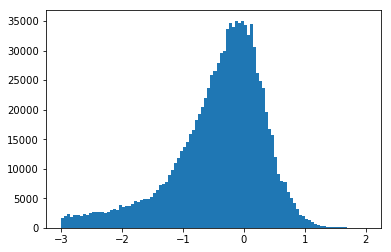

In [35]:
print(hdu.data.max())
print(hdu.data.min())
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100 )
plt.show()

Once we know the range of the data, we can do a visualization with the proper range (```vmin``` and ```vmax```).

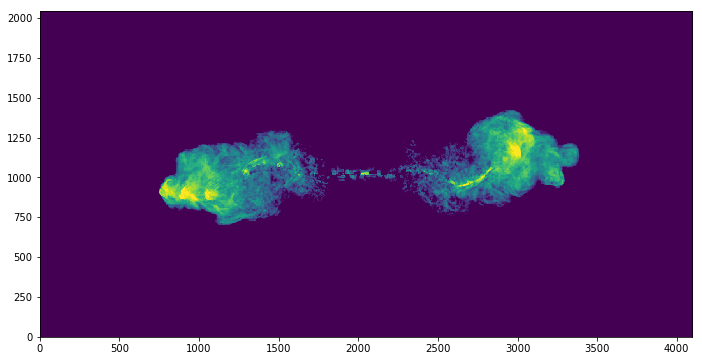

In [36]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(111)

# We plot it in log-scale and add a small number to avoid nan values. 
# We also transpose the data for compact presentation in the notebook
plt.imshow(np.log10(hdu.data+1E-3).transpose(), vmin=-1, vmax=1, origin='lower')
plt.show()

## 2. Set up astrometry coordinates

From the header, we know that the x and y axes are in centimeter. However, in an observation we usually have RA and DEC. To convert physical units to sky coordinates, we will need to make some assumptions about where the object is located, i.e. the distance to the object and the central RA and DEC. 

In [ ]:
# Distance to the object
dist_obj = 200*u.Mpc

# Here we have the RA in hh:mm:ss format and DEC in dd:mm:ss. We will use Skycoord to convert them into degrees.
ra_obj = '19h59m28.3566s'
dec_obj = '+40d44m02.096s'

Here we convert the pixel scale from cm to degree by dividing the distance to the object.

In [38]:
cdelt1 = ((hdu.header['CDELT1']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
cdelt2 = ((hdu.header['CDELT2']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
print(cdelt1, cdelt2)

8.749222239908287e-06 deg 8.749222239908287e-06 deg


In [3]:
w = WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0]/2,hdu.data.shape[1]/2]
# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# converting ra and dec into degrees
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

w.wcs.cunit = ['deg', 'deg']

Convert the wcs coordinate into header and update the hdu.

In [4]:
wcs_header = w.to_header()
hdu.header.update(wcs_header)

In [39]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =               1024.5                                                  
CRPIX2  =               2048.5                                                  
CDELT1  = 9.42382812499999E+

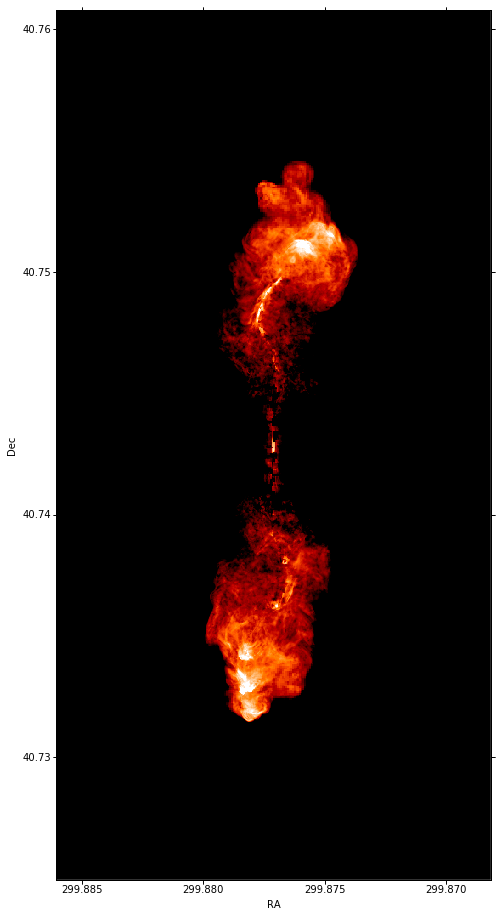

In [6]:
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(8,16))
fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(hdu.data+1e-3), cmap='gist_heat', vmin=-1, vmax=1, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Now we have the sky coordinate for the image!

## 3. Prepare a Point Spread Function (PSF)

8.749222239908287e-06 deg
0.0002777777777777778 deg
31.748853802196887


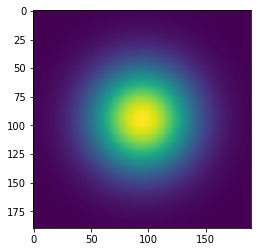

In [37]:
telescope_resolution=1*u.arcsecond
sigma=telescope_resolution.to('deg')/cdelt2
print(cdelt2)
print(telescope_resolution.to('deg'))
print(sigma)

x_grid=np.linspace(-sigma*3,sigma*3,int(6*sigma))

gauss=np.exp(-(x_grid**2/(2.*sigma**2)))
psf=np.outer(gauss,gauss)
psf/=np.sum(psf)
plt.imshow(psf)
plt.show()

## 4. Convolve image with PSF

In [14]:
from astropy.convolution import convolve_fft
delta_x_psf=100
convolved_image = convolve_fft(hdu.data, psf, boundary='wrap')

# Put a psf at the corner of the image
convolved_image[delta_x_psf:delta_x_psf+int(6*sigma),-int(6*sigma)-delta_x_psf:-delta_x_psf]=psf/np.max(psf)*10

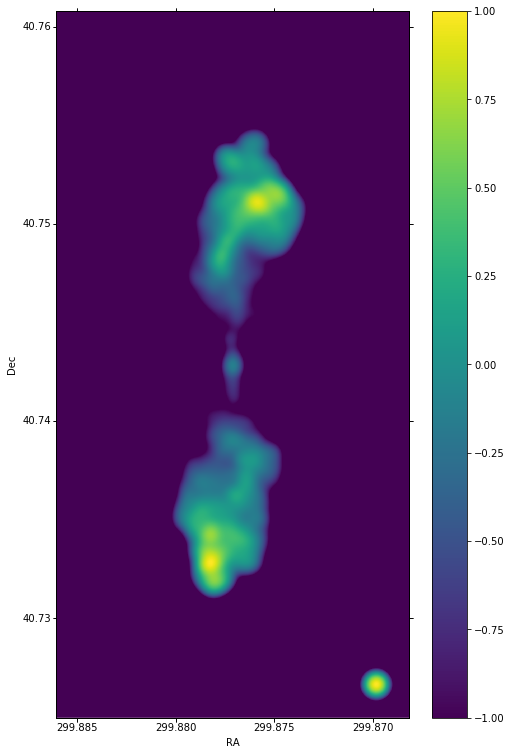

In [15]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(8,13))
i_plot = fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

## 5. Add some noise to the data

## 6. Convolve Stokes Q and U images

In [16]:
hdulist = fits.open('./synchrotron_q_lobe_0700_150MHz.fits')
hdu_q = hdulist['NN_EMISSIVITY_Q_LOBE_150.0MHZ']
hdulist = fits.open('./synchrotron_u_lobe_0700_150MHz.fits')
hdu_u = hdulist['NN_EMISSIVITY_U_LOBE_150.0MHZ']

hdu_q.header.update(wcs_header)
hdu_u.header.update(wcs_header)
convolved_image_q = convolve_fft(hdu_q.data, psf, boundary='wrap')
convolved_image_u = convolve_fft(hdu_u.data, psf, boundary='wrap')


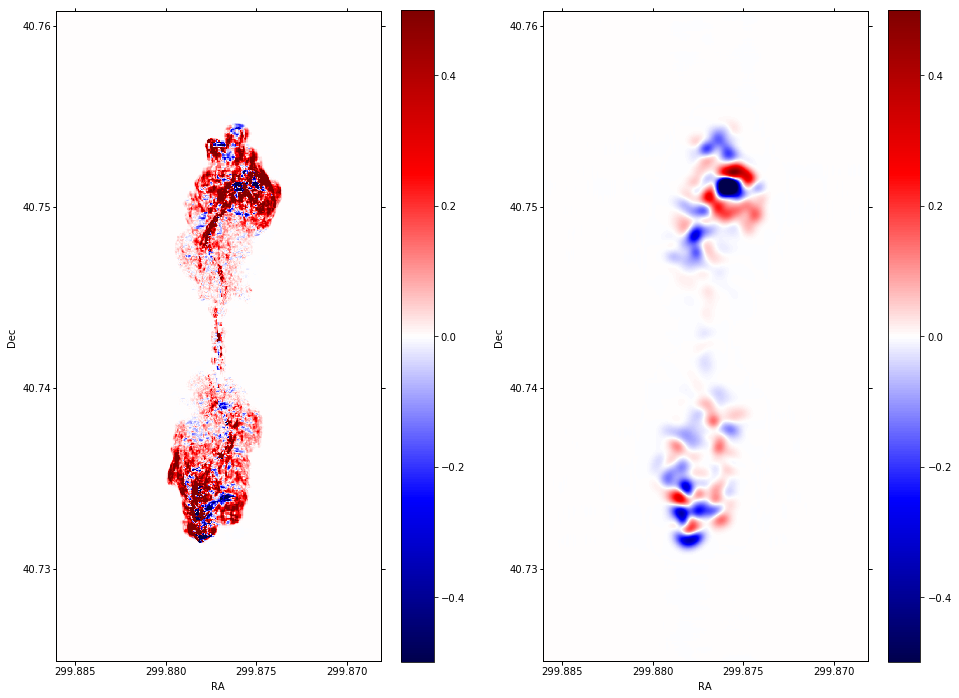

In [17]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(16,12))
fig.add_subplot(121, projection=wcs)
plt.imshow(hdu_q.data, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

fig.add_subplot(122, projection=wcs)
plt.imshow(convolved_image_u, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

## 7. Add quiver plot 

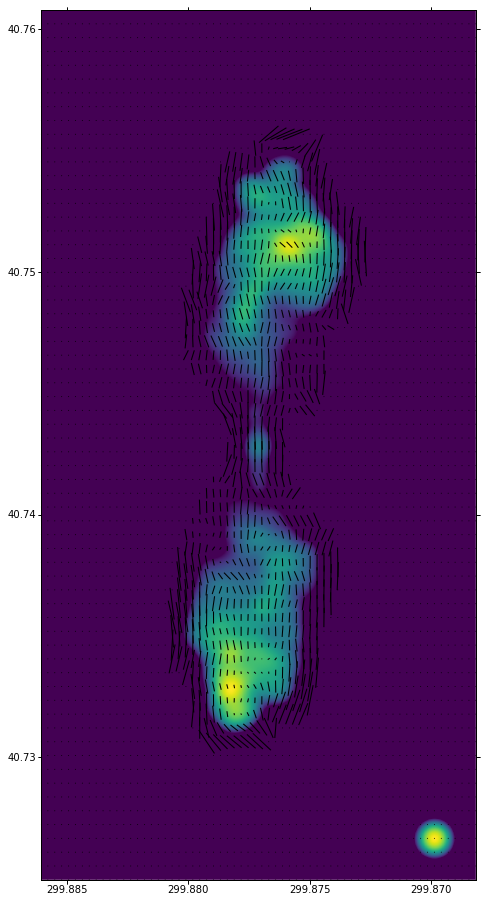

In [18]:
fig = plt.figure(figsize=(8,16))
i_plot = fig.add_subplot(111, projection=wcs)

i_plot.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1, origin='lower')

# binning factor
factor = [64, 32]

xx0, xx1 = i_plot.get_xlim()
yy0, yy1 = i_plot.get_ylim()

nx = convolved_image.shape[0] // factor[0]
ny = convolved_image.shape[1] // factor[1]

X,Y = np.meshgrid(np.linspace(xx0,xx1,nx,endpoint=True),
                  np.linspace(yy0,yy1,ny,endpoint=True))

# Bin the data
I_bin = convolved_image.reshape(nx, factor[0], ny, factor[1]).sum(3).sum(1)
Q_bin = convolved_image_q.reshape(nx, factor[0], ny, factor[1]).sum(3).sum(1)
U_bin = convolved_image_u.reshape(nx, factor[0], ny, factor[1]).sum(3).sum(1)

# Polarization angle
psi = 0.5*np.arctan2(U_bin, Q_bin)
# Polarization fraction
frac = np.sqrt(Q_bin**2+U_bin**2)/I_bin

# mask for low signal area
mask = I_bin < 0.1

frac[mask] = 0
psi[mask] = 0

# Rotated 90 deg to show the direction of magnetic fields
pixX = frac*np.sin(psi)
pixY = frac*np.cos(psi)



quiveropts = dict(headlength=0, headwidth=1, pivot='middle')
i_plot.quiver(X, Y, pixX, pixY, scale=8, **quiveropts)
plt.show()

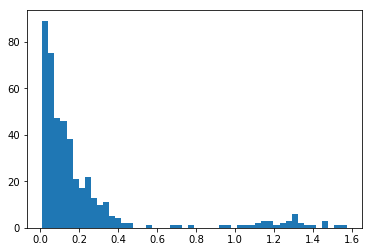

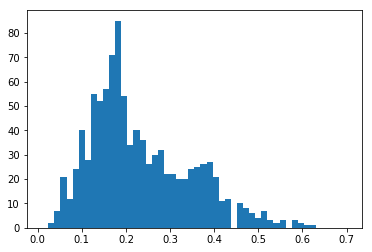

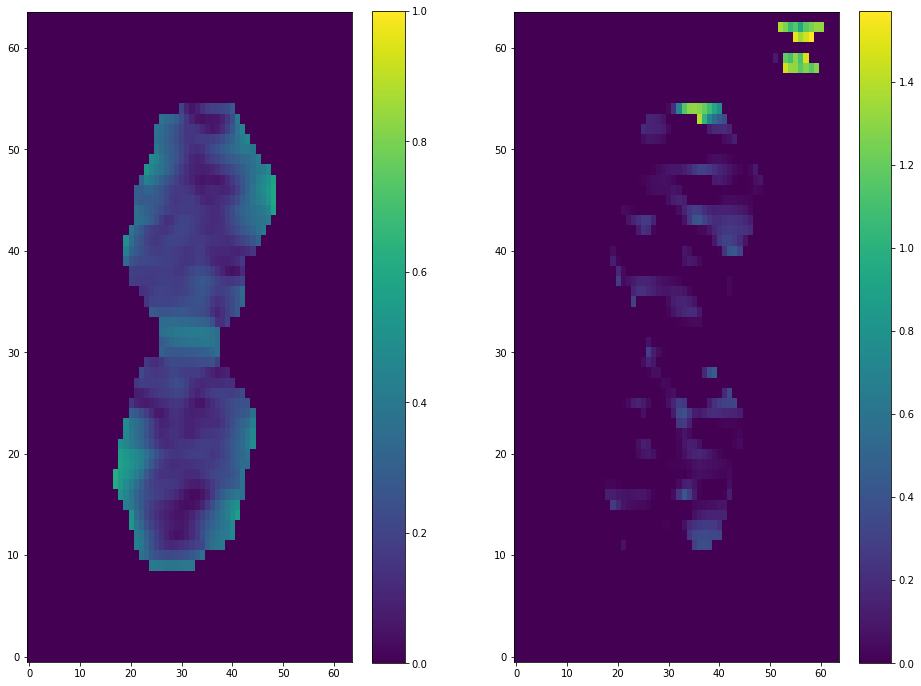

In [133]:
null = plt.hist(psi.flatten(), range=(0.01,np.pi/2), bins=50)
plt.show()
null = plt.hist(frac.flatten(), range=(0.01, 0.7), bins=50)
plt.show()
#plt.imshow(frac, vmin=0, vmax=1, aspect=2)
fig = plt.figure(figsize=(16,12))
fig.add_subplot(121)
plt.imshow(frac, vmin=0, vmax=1, origin='lower', aspect=2)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(psi, vmin=0, vmax=np.pi/2, origin='lower', aspect=2)
plt.colorbar()


plt.show()

In [135]:
pixX[20:30,20:30]

array([[ -4.11183206e-02,  -2.80537878e-02,  -1.39540860e-02,
          6.86400062e-04,   1.46231994e-02,   2.31758691e-02,
          2.15764605e-02,   1.20298458e-02,   2.50422588e-03,
         -1.95592929e-03],
       [ -2.88542578e-02,  -2.02538827e-02,  -9.10307474e-03,
          3.24895909e-03,   1.57912260e-02,   2.27924598e-02,
          1.61927290e-02,  -4.12858672e-03,  -2.71221606e-02,
         -3.79525421e-02],
       [ -5.09522554e-02,  -4.60594192e-02,  -4.04322054e-02,
         -3.52881481e-02,  -3.15745934e-02,  -3.31090858e-02,
         -4.57132973e-02,  -6.83660079e-02,  -8.26846401e-02,
         -7.56993870e-02],
       [ -5.96671634e-02,  -5.85089660e-02,  -5.58154605e-02,
         -5.21175379e-02,  -4.71370823e-02,  -4.36732281e-02,
         -4.79107190e-02,  -5.62781769e-02,  -5.94363954e-02,
         -5.24391283e-02],
       [ -2.14298654e-02,  -2.09862519e-02,  -1.69610269e-02,
         -9.86401767e-03,  -1.36956788e-04,   4.63080256e-03,
         -9.04791155e-04